# Import necessary packages and libraries

In [1]:
import pandas as pd
import numpy as np
import tempfile
import PIL
import matplotlib.pyplot as plt
import pickle
import time
%matplotlib inline

# Image Cropping/Edge Detection Pipeline
The function below will take in an image, crop it around the edge case bounds of ink signal, and then return a square version of the image using symmetrical padding. 

In training, this will allow our model to learn from images that are standardized in size as it relates to the scan itself outside of the blank space surrounding borders while ensuring the ink signal itself represents most of the introduced data.

During testing/production, applying this transformation to images will allow our model to make predictions accurately regardless of the original size of the scan therefore making the model resistance to original size and position of the ink signal.

In [49]:
brain_scans = pickle.load(open('Amit/Labeled Data/labeled_data.pkl','rb')).iloc[:100,:-1]

In [74]:
def crop_single_image(image_vector,old_dim,new_dim,show_stages = True):
    #Store Vector as a 2D vector (square pixel representation of image)
    image_vector_2d = np.array(image_vector.copy()).reshape(old_dim)
    
    if show_stages == True:
        print('Original Image')
        plt.imshow(image_vector_2d,cmap='gray')
        plt.show()
    
    #Store max ink signal across rows and columns
    row_maxes = np.max(image_vector_2d,axis=1)
    col_maxes = np.max(image_vector_2d,axis=0)
    
    #Find tightest possible bounds for image where ink signal begins and ends
    #LEFT/RIGHT BOUNDS, TOP/BOTTOM BOUNDS
    left_most,right_most,top_most,bottom_most = 0,0,0,0
    switch_col = 0 #toggle to switch between capturing left most ink signal and right most ink signal
    switch_row = 0 #toggle to switch between capturing top most ink signal and bottom most ink signal
    for num in range(len(row_maxes)):
        #LEFT/RIGHT BOUNDS
        if switch_col == 0 and col_maxes[num] != 0:
            left_most = num
            switch_col = 1
        elif switch_col == 1 and col_maxes[num] == 0:
            right_most = num - 1
            switch_col = 2
            
        #TOP/BOTTOM BOUNDS
        if switch_row == 0 and row_maxes[num] != 0:
            top_most = num
            switch_row = 1
        elif switch_row == 1 and row_maxes[num] == 0:
            bottom_most = num - 1
            switch_row = 2
        
        #Early break if cropped bounds have been found
        if switch_col == 2 and switch_row == 2:
            break
        
        #If on last iteration bottom or right bound has not been found
        if num == len(row_maxes) - 1 and switch_col == 1:
            right_most = num
        if num == len(row_maxes) - 1 and switch_row == 1:
            bottom_most = num

    #Cropped image vector according to bounds identified
    cropped_image_vector_2d = image_vector_2d[top_most:bottom_most + 1,left_most:right_most + 1].copy()
    
    if show_stages == True:
        print('Cropped Image around top/bottom most and left/right most instances of ink signal')
        plt.imshow(cropped_image_vector_2d,cmap='gray')
        plt.show()
    
    #Cast image as a square image if needed to preserve aspect ratios
    #Capture shape of cropped image and difference in size across dimensions
    height,width = cropped_image_vector_2d.shape
    size_diff = abs(height - width) #diff between height and width dimensions
    gapfill_1 = int(size_diff/2) #amount of blank space to add to one side of shorter dimension
    gapfill_2 = size_diff - gapfill_1 #amount of blank space to add to the other side
    
    if height < width: #if height of image is less than width, add symmetrical padding height wise to make image square
        #Add symmetrical blank spacing to top and bottom of image
        cropped_image_vector_2d = np.vstack((np.zeros((gapfill_1,width)),cropped_image_vector_2d)) #Add to top
        cropped_image_vector_2d = np.vstack((cropped_image_vector_2d,np.zeros((gapfill_2,width)))) #Add to bottom
    elif width < height: #if width of image is less than height, add symmetrical padding width wise to make image square
        cropped_image_vector_2d = np.hstack((np.zeros((height,gapfill_1)),cropped_image_vector_2d)) #Add to left
        cropped_image_vector_2d = np.hstack((cropped_image_vector_2d,np.zeros((height,gapfill_2)))) #Add to right
    
    if show_stages == True and height != width:
        print('Centered Version of Cropped Image with symmetric padding added to short axis')
        plt.imshow(cropped_image_vector_2d,cmap='gray')
        plt.show()
        
    #Resize as needed (only if cropped image is not the size of the new dimensions)
    height,width = cropped_image_vector_2d.shape
    if (height,width) != new_dim:
        temp = tempfile.TemporaryFile()
        plt.imsave(temp,cropped_image_vector_2d,cmap='gray') #save array as image
        img = PIL.Image.open(temp).convert('L') #open greyscale image
        img = img.resize(new_dim) #resize to new dimensions
        cropped_image_vector_2d = np.array(img)
    
    if show_stages == True:
        print('Final Image')
        plt.imshow(cropped_image_vector_2d,cmap='gray')
        plt.show()
    
    return cropped_image_vector_2d

In [64]:
test_scan = brain_scans.iloc[8]

Original Image


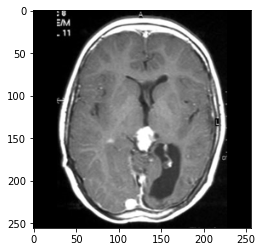

Cropped Image around top/bottom most and left/right most instances of ink signal


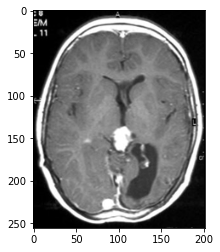

Centered Version of Cropped Image with symmetric padding added to short axis


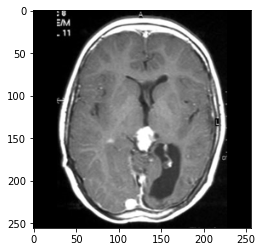

Final Image


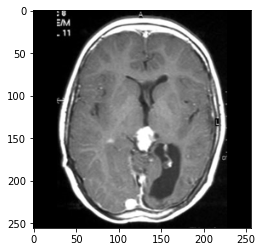

here


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
crop_single_image(test_scan,(256,256),(256,256),True)

In [66]:
# time eval
timer = time.time()
crop_single_image(test_scan,(256,256),(256,256),False)
print(time.time()-timer)

here
0.0029630661010742188


0.015 seconds per image cropping, approximately 46 seconds to crop the whole dataset

The function below will take a dataset of image vectors and apply the cropping/edge detection function above to each image before returning a modified image vector

In [103]:
def crop_dataset(image_dataset,old_dim,new_dim):
    cropped_images = []
    for num in range(len(image_dataset)):
        scan = image_dataset.iloc[num].copy()
        cropped_images.append(crop_single_image(scan,old_dim,new_dim,False).flatten())
    
    if type(cropped_images[0][0]) == np.uint8:
        cropped_images = pd.DataFrame(cropped_images,columns=image_dataset.columns).astype('uint8')
    else:
        cropped_images = pd.DataFrame(cropped_images,columns=image_dataset.columns).astype('float16')
        
    return cropped_images

In [105]:
df = crop_dataset(brain_scans.iloc[:10],(256,256),(256,256))